<a href="https://colab.research.google.com/github/easyri/paintings/blob/master/paintings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Предсказание стоимости картин с помощью Transfer Learning

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving new_dataset.csv to new_dataset.csv
Saving new_imgarray.npy to new_imgarray.npy


(нужно загрузить new_dataset.csv и img_arrays.npy)

In [ ]:
! pip install git+https://github.com/tensorflow/docs


In [ ]:
import pandas as pd
import numpy as np
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import os, glob, cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator


 Предварительная подготовка: загружаем изображения, приводим к одному размеру и помещаем в numpy array (не требуется)

In [ ]:
# перед запуском предварительно загрузить data_set.csv
def download_image(url, name):
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.exceptions.HTTPError:
        print("http error with {}".format(name))
    else:
        file = open("{}.jpg".format(name), 'wb')
        file.write(response.content)
        file.close()


# конвертирует изображеня в np-array
def image_to_array(image_path):
    size = (128, 128)
    with Image.open(image_path) as image:
        image.resize(size)
        data = np.asarray(image)
    return data


if __name__ == "__main__":
    data = pd.read_csv("data_set.csv")
    for i in range(data["Image"].size):
        if ".jpg" not in data["Image"][i]:               # удаляем пустые ссылки
            # print(i, data["Image"][i], sep=' ', end='\n')
            data = data.drop([i])
    data.index = [i for i in range(data["Image"].size)]  # приводим индексы в порядок
    if "downloaded_image" not in data.columns:           # загружаем изображения в память
        addresses = []
        arrays = []
        size = 254, 254
        for i in range(data["Image"].size):
            download_image(data['Image'][i], str(i))
            addresses.append("{}.jpg".format(str(i)))
            img = Image.open("{}.jpg".format(str(i)))
            img = img.resize(size)
            img = np.asarray(img)
            if img.shape != (254, 254, 3):
                # черно-белый формат -->> цветной
                rgbimg = Image.new("RGB", Image.fromarray(img).size)
                rgbimg.paste(Image.fromarray(img))
                rgbimg = np.asarray(rgbimg)
                arrays.append(rgbimg)
            else:
                arrays.append(img)
        data["downloaded_image"] = addresses
        data.to_csv("new_dataset.csv", index=False)
        np.save('new_img_arrays', arrays)

    

In [ ]:
X = np.load("new_imgarray.npy")

тестим просмотр

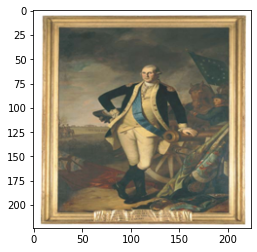

In [ ]:
%matplotlib inline
imshow(X[0])

In [ ]:
# приводим в порядок формат целевой переменной
dataset = pd.read_csv("new_dataset.csv")
y = list(dataset["Price"])
for i in range(len(y)):
  y[i] = y[i].replace(',', '')  # цена оказалась в виде строки с запятыми 
y = np.asarray(y, dtype=int)
# dataset.head()




In [ ]:
# разделяем данные для обучения и теста
X_train, X_test, y_train, y_test = train_test_split(X, y)       
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test)



Сначала построим cnn и обучим на тестовой выборке

In [ ]:
input_shape = 224, 224, 3   # константы для cnn
epochs = 30
batch_size = 30

In [ ]:
def build_model():          
  model = keras.Sequential()

  model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(64, activation='relu', input_shape=[len(y_train)]))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 64)      9280      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 86528)            

In [ ]:
history = model.fit(x=X_train,y=y_train,  batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_val, y_val), shuffle=True,callbacks=[early_stop, tfdocs.modeling.EpochDots()])

Train on 291 samples, validate on 73 samples
Epoch 1/30
291/291 [==============================] - 11s 39ms/step - loss: 636447665852036.0000 - mae: 18059272.0000 - mse: 636447648382976.0000 - val_loss: 243572696549123.5312 - val_mae: 10017791.0000 - val_mse: 243572678852608.0000

Epoch: 0, loss:636447665852036.0000,  mae:18059272.0000,  mse:636447648382976.0000,  val_loss:243572696549123.5000,  val_mae:10017791.0000,  val_mse:243572678852608.0000,  
.Epoch 2/30
291/291 [==============================] - 11s 37ms/step - loss: 347966441064426.8750 - mae: 11764611.0000 - mse: 347966405607424.0000 - val_loss: 219476111414314.0938 - val_mae: 9566942.0000 - val_mse: 219476117159936.0000
.Epoch 3/30
291/291 [==============================] - 11s 37ms/step - loss: 339696942563496.9375 - mae: 11810909.0000 - mse: 339696949395456.0000 - val_loss: 228755908580842.9375 - val_mae: 9641051.0000 - val_mse: 228755897319424.0000
.Epoch 4/30
291/291 [==============================] - 11s 37ms/step - lo

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() # динамика потерь и ошибок во время тренировки и валидации:


,val_loss,val_mae,val_mse,loss,mae,mse,epoch
15,2.099432e+14,9460951.0,2.099432e+14,3.307298e+14,11867461.0,3.307298e+14,15
16,2.154972e+14,10419472.0,2.154972e+14,3.318740e+14,11687147.0,3.318740e+14,16
17,2.138082e+14,10377084.0,2.138082e+14,3.268963e+14,11718587.0,3.268963e+14,17
18,2.261199e+14,11309110.0,2.261199e+14,3.212388e+14,11524613.0,3.212389e+14,18
19,2.920327e+14,14208676.0,2.920327e+14,3.211331e+14,11501221.0,3.211331e+14,19


Результаты так себе, но лучшего никто и не ожидал

построим графики метрик:

In [ ]:
def plt_errors(history, dfhistory):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  t = f.suptitle('Basic CNN Performance', fontsize=12)
  f.subplots_adjust(top=0.85, wspace=0.3)

  epoch_list = list(range(1, len(dfhistory['epoch']) + 1))
  ax1.plot(epoch_list, history.history['mae'], label='Train mae')
  ax1.plot(epoch_list, history.history['val_mae'], label='Validation mae')
  ax1.set_xticks(np.arange(0, 31, 5))
  ax1.set_ylabel('mae Value')
  ax1.set_xlabel('Epoch')
  ax1.set_title('mae')
  l1 = ax1.legend(loc="best")

  ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
  ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
  ax2.set_xticks(np.arange(0, 31, 5))
  ax2.set_ylabel('Loss Value')
  ax2.set_xlabel('Epoch')
  ax2.set_title('Loss')
  l2 = ax2.legend(loc="best")


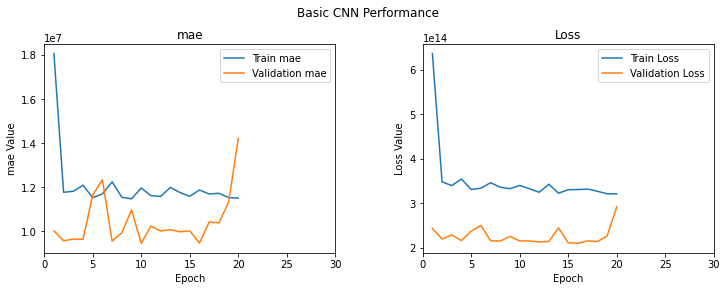

In [ ]:
plt_errors(history, hist)

ошибки на тестовых данных:

In [ ]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=1)

25/25 [==============================] - 0s 11ms/step


In [ ]:
predictions = model.predict(X_test).flatten()
# print(predictions)


Посмотрим на отличия между реальными и предсказанными значениями:

In [ ]:
def plt_values(y_test, predictions, lims):
  a = plt.axes(aspect='equal')
  plt.scatter(y_test, predictions)
  plt.xlabel('true values')
  plt.ylabel('predicted values')
  plt.xlim(lims)
  plt.ylim(lims)
  _=plt.plot(lims, lims)

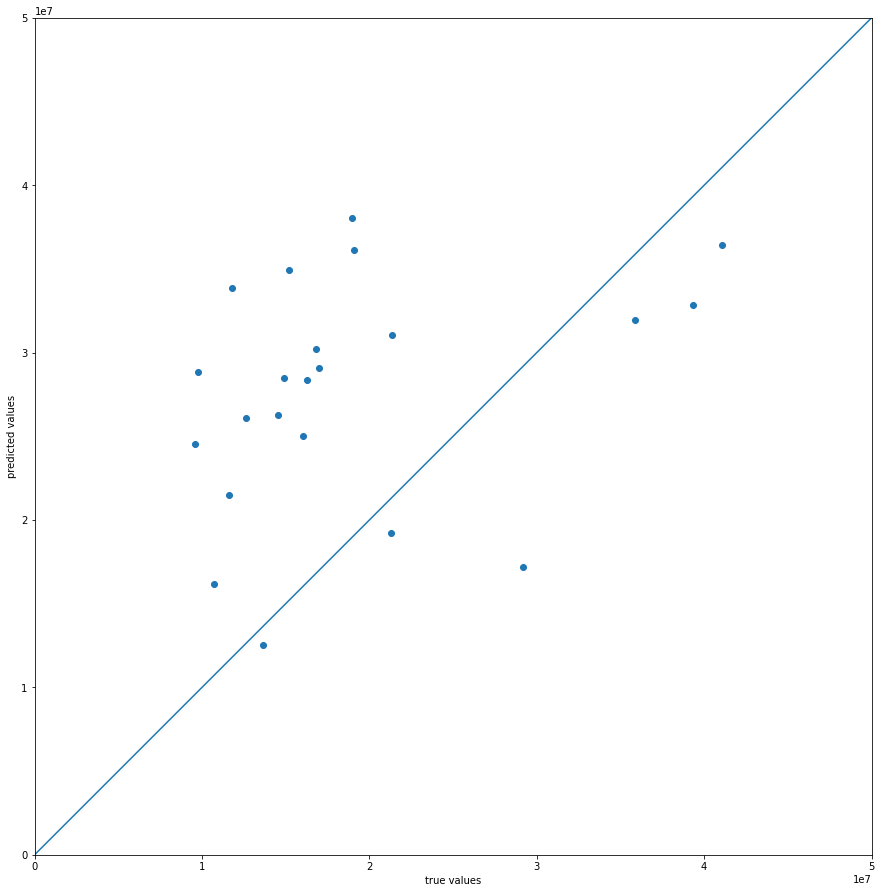

In [ ]:
plt_values(y_test, predictions, [0, 50000000])

Попробуем улучшить результат, добавив dropout

In [ ]:
def build_better_model():
  model = keras.Sequential()

  model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(64, activation='relu', input_shape=[len(y_train)]))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(1))
  

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
  

также добавим early stop, дабы не переобучаться

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [ ]:
model2 = build_better_model()
history2 = model2.fit(x=X_train,y=y_train,  batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_val, y_val), shuffle=True,callbacks=[early_stop, tfdocs.modeling.EpochDots()])

In [ ]:
hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
hist2.tail()



,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,3.534099e+14,12216120.0,3.600926e+14,1.754504e+14,10315636.0,2.044643e+14,5
6,3.549085e+14,12031328.0,3.600903e+14,2.020324e+14,10118563.0,2.340989e+14,6
7,3.775329e+14,12136439.0,3.859962e+14,1.900583e+14,9994988.0,2.212027e+14,7
8,3.520176e+14,11767736.0,3.576560e+14,1.757469e+14,10158105.0,2.051058e+14,8
9,3.419055e+14,11884849.0,3.499621e+14,2.100459e+14,10249388.0,2.429235e+14,9


In [ ]:
loss, mae, mse = model2.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 2ms/step - loss: 292514619719680.0000 - mae: 11399707.0000 - mse: 292514619719680.0000


- mae немного уменьшилась, но не сказать, что нам это помогло

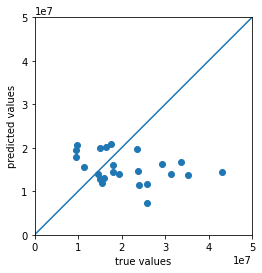

In [ ]:
predictions2 = model2.predict(X_test).flatten()
plt_values(y_test, predictions2, [0, 50000000])

попробуем отнормировать данные:

In [ ]:
X_train_scaled = X_train / 255
X_val_scaled = X_val / 255
X_test_scaled = X_test / 255

In [ ]:
model3 = build_better_model()
history3 = model3.fit(x=X_train_scaled, y=y_train, batch_size=batch_size, epochs=epochs, verbose=1,
                      validation_data=(X_val_scaled, y_val), callbacks=[early_stop, tfdocs.modeling.EpochDots()], shuffle=True)

mae и mse немного уменьшились 

1/1 [==============================] - 0s 1ms/step - loss: 370560718602240.0000 - mae: 13558470.0000 - mse: 370560718602240.0000


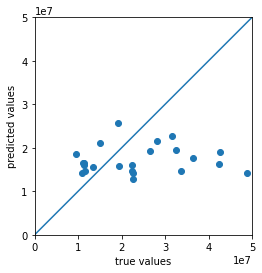

In [ ]:
loss, mae, mse = model3.evaluate(X_test_scaled, y_test, verbose=1)
predictions3=model3.predict(X_test_scaled).flatten()
plt_values(y_test, predictions3, [0, 50000000])

In [ ]:
hist3 = pd.DataFrame(history3.history)
hist3['epoch'] = history3.epoch
hist3.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
14,2.729999e+14,10923790.0,2.729999e+14,5.473312e+14,14109870.0,5.473312e+14,14
15,2.589687e+14,10755232.0,2.589687e+14,5.473759e+14,13740360.0,5.473759e+14,15
16,2.617172e+14,10680045.0,2.617172e+14,5.617547e+14,12691342.0,5.617547e+14,16
17,2.700943e+14,10985704.0,2.700943e+14,5.553995e+14,12907753.0,5.553995e+14,17
18,2.608397e+14,10487396.0,2.608397e+14,5.499371e+14,13214201.0,5.499371e+14,18


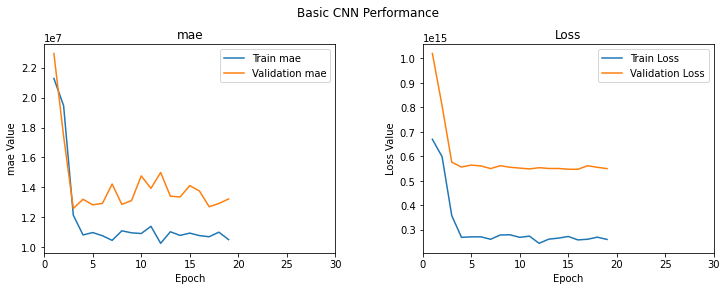

In [ ]:
plt_errors(history3, hist3)

добавим еще изображений для тренировки, исказив старые:

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

посмотрим, что получается:

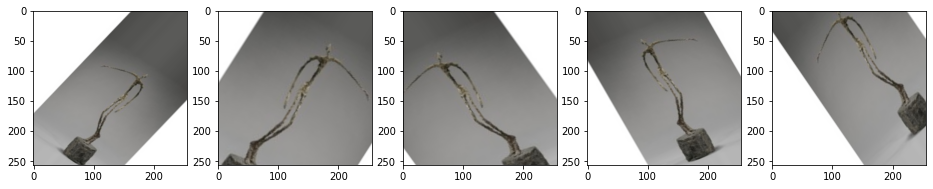

In [ ]:
test_generator = train_datagen.flow(X_train[0:1], y_train[0:1], batch_size=1)
pic = [next(test_generator) for i in range(5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
l = [ax[i].imshow(pic[i][0][0]) for i in range(5)]

In [ ]:
train_gen = train_datagen.flow(X_train_scaled, y_train, batch_size=30)
val_gen = val_datagen.flow(X_val_scaled, y_val, batch_size=10)


In [ ]:
model4 = build_better_model()
history4 = model4.fit_generator(train_gen, steps_per_epoch= len(X_train)/30, epochs=20,
                                validation_data=val_gen, validation_steps=len(X_val)/10,
                                verbose=1, callbacks=[early_stop])

In [ ]:
hist4 = pd.DataFrame(history4.history)
hist4['epoch'] = history4.epoch
hist4.tail()

похоже на переобучение, которое здесь не получается лечить ни изменением batch size, ни learning rate. Видимо, виноват небольшой размер датасета

In [ ]:
loss, mae, mse = model4.evaluate(X_test_scaled, y_test, verbose=1)

In [ ]:
plt_errors(history4, hist4)

In [ ]:
preds4 = model4.predict(X_test_scaled).flatten()
print(preds4)
plt_values(y_test, preds4, [0, 50000000])

наконец, попробуем перейти к transfer learning

ResNet50:

In [ ]:

from keras.applications import vgg16
from keras.models import Model
import keras 
from keras import layers
import torch
from torch import nn
from collections import OrderedDict
import argparse
import os
from torchvision import transforms, utils, datasets, models
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import time
import glob
import copy
import shutil
import sys
from matplotlib.ticker import MaxNLocator


In [ ]:
форматируем данные и кидаем в датасет,который пойдет в генератор для модели

In [ ]:
class Dataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, labels):
        'Initialization'
        self.data = torch.from_numpy(data)
        self.labels = torch.LongTensor(labels)

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, index):
        'Generates one sample of data'
        x = self.data[index]
        y = self.labels[index]
        return x, y

In [ ]:
print(X_train_scaled.shape)
X_train_scaled = np.moveaxis(X_train_scaled, -1, 1)
X_train_scaled.shape

(291, 224, 224, 3)


(291, 3, 224, 224)

In [ ]:
X_val_scaled = np.moveaxis(X_val_scaled, -1, 1).astype(np.float32)
X_test_scaled = np.moveaxis(X_test_scaled, -1, 1).astype(np.float32)

In [ ]:
X_train_scaled = X_train_scaled.astype(np.float32)

In [ ]:
train = Dataset((X_train_scaled), y_train)
train_gen = DataLoader(train, batch_size=32, shuffle=True)

val = Dataset((X_val_scaled), y_val)
val_gen = DataLoader(val, batch_size=32, shuffle=True)

In [ ]:
test = Dataset(X_test_scaled, y_test)
test_gen = DataLoader(test, batch_size=1, shuffle=True)

загружаем модель, заменяем последний слой на классификатор, сохраняя веса


In [ ]:
def build_transfer():
  model = models.__dict__['resnet50'](pretrained=True)

  for param in model.parameters():
    param.require_grad = False
  last_layer = list(model.children())[-1]
  count = 0
  in_features = last_layer.in_features
  classifier = nn.Sequential(OrderedDict([
                          ('bc1', nn.BatchNorm1d(in_features)),
                          ('relu1', nn.ReLU()),
                          ('fc1', nn.Linear(in_features, 1, bias=True)),
  ]))
  if model.__dict__['_modules'].get('fc', None):
      model.fc = classifier
  else:
      model.classifier = classifier

  return model

# build_transfer()

In [ ]:
def train_model(model, train_gen, valid_gen, criterion, optimizer, scheduler, epochs, diff_lr=False):
  
  start = time.time()
  print_every = 50
  steps = 0
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  valid_loss_min = np.Inf
  training_loss, validation_loss = [], []
  for epoch in range(epochs):
      lr_used = 0
      if diff_lr:
        for param in optimizer.param_groups:
          if param['lr'] > lr_used:
            lr_used = param['lr']
        print('learning rate being used {}'.format(lr_used))      
      running_loss = 0
      # train_acc = 0
      scheduler.step()
      model.train()
      for idx, (images, prices) in enumerate(train_gen):
          steps += 1
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward pass and backward pass
          output = model(images)
          
          loss = criterion(prices, output)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          
      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():
          valid_loss = validation(model, valid_gen, criterion)
          
      if valid_loss < valid_loss_min:
          valid_loss_min = valid_loss
          best_model_wts = copy.deepcopy(model.state_dict())

      print("Epoch: {}/{}... ".format(epoch+1, epochs),
        "Train loss: {:.4f}".format(running_loss/len(train_gen.dataset)),
        "Validation loss: {:.4f}".format(valid_loss/len(valid_gen.dataset)),
        )
      # save the losses
      training_loss.append(running_loss/len(train_gen.dataset))
      validation_loss.append(valid_loss/len(valid_gen.dataset))
      running_loss = 0       
      
  print('Best validation loss is {:.4f}'.format(valid_loss_min/len(valid_gen.dataset)))
  print('Time to complete training {} minutes'.format((time.time() - start) / 60))
  model.load_state_dict(best_model_wts)
  return model, training_loss, validation_loss


In [ ]:
def optimizer(model, lr=0.001, weight_decay=1e-3/200):
    
    if model.__dict__['_modules'].get('fc', None):
        return optim.Adam(model.fc.parameters(), lr=lr, weight_decay=weight_decay)
    return optim.Adam(model.classifier.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
def validation(model, valid_gen, criterion=None):

    valid_loss = 0
    model.eval()
    for images, prices in valid_gen:

        # images, prices = images.to(device), prices.to(device)
        output = model(images)
        valid_loss += criterion(prices, output).item() * images.size(0)
    
    return valid_loss

In [ ]:
def check_on_test(model, test_gen, criterion):  
    # Compute the Root Mean Square Error on the test dataset
    loss = 0
    model.eval()
    with torch.no_grad():
        for data in test_gen:
            images, prices = data
           
            outputs = model(images)
            loss += criterion(prices, outputs)
        loss = np.squeeze(loss.cpu().numpy()) 

    return loss / len(test_gen)

In [ ]:
def predict_prices(model, test_gen):
  model.eval()
  predictions = []
  for data in test_gen:
    image, price = data
    prediction = int(model(image)[0][0])
    predictions.append(prediction*1e6)
  return predictions

# preds= predict_prices(model, test_gen)
# print(preds)

In [ ]:
epochs = 10
lr = 0.001

In [ ]:
model = build_transfer()
#  criterion = torch.nn.L1Loss()
criterion = torch.nn.MSELoss()
optim_ = optimizer(model, lr)
#exp_lr_scheduler = lr_scheduler.StepLR(optim_, step_size=5, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optim_, T_max=epochs)

In [ ]:
model, training_loss, validation_loss = train_model(model, train_gen, 
                                                      val_gen, criterion, 
                      optim_, exp_lr_scheduler, epochs, False) 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (to

Epoch: 1/10...  Train loss: 780371136802182.6250 Validation loss: 612244442201887.5000
Epoch: 2/10...  Train loss: 780370789669476.2500 Validation loss: 612244116769862.1250
Epoch: 3/10...  Train loss: 780370474938128.7500 Validation loss: 612243845576507.6250
Epoch: 4/10...  Train loss: 780370179693719.3750 Validation loss: 612243565190158.0000
Epoch: 5/10...  Train loss: 780369980212044.5000 Validation loss: 612243279288011.3750
Epoch: 6/10...  Train loss: 780369783036516.2500 Validation loss: 612243238838833.1250
Epoch: 7/10...  Train loss: 780369657582145.1250 Validation loss: 612243127143943.0000
Epoch: 8/10...  Train loss: 780369594278422.8750 Validation loss: 612243092210561.7500
Epoch: 9/10...  Train loss: 780369570409806.2500 Validation loss: 612243015449052.8750
Epoch: 10/10...  Train loss: 780369558648459.0000 Validation loss: 612243065550876.0000
Best validation loss is 612243015449052.8750
Time to complete training 18.24741864601771 minutes


In [ ]:
test_loss = check_on_test(model, train_gen, criterion)
print('Test set loss is {:.4f}'.format(test_loss))
    

In [ ]:
ну нет так нет))) а чего ожидать от датасета на 389 изображений

In [ ]:
predicted_prices = predict_prices(model, test_gen)

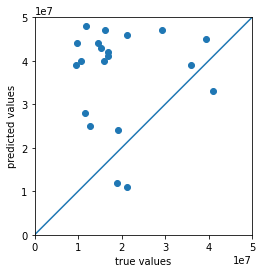

In [ ]:
plt_values( y_test, predicted_prices, [0, 50000000])

но есть и красивые графики:

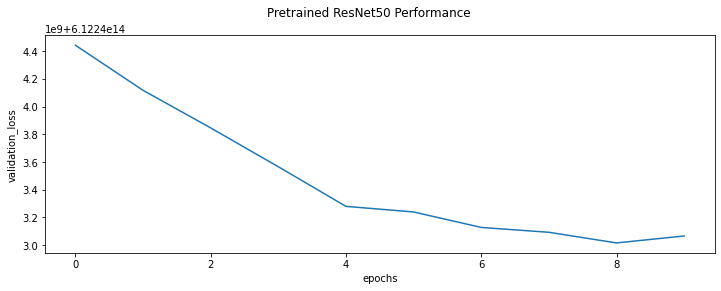

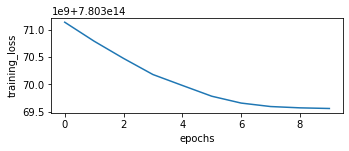

In [ ]:


plt.figure(1, figsize=(12, 4))
plt.suptitle('Pretrained ResNet50 Performance', fontsize=12)
plt.subplot(111)
plt.ylabel('validation_loss')
plt.xlabel('epochs')
plt.plot(validation_loss)

plt.figure(2, figsize=(12, 4))
plt.subplot(222)
plt.ylabel('training_loss')
plt.xlabel('epochs')
plt.plot(training_loss)
plt.subplots_adjust(top=0.85, wspace=0.3)
  

попробуем другую модель

vgg16

In [ ]:
def build_transfer_vgg():
  model = models.__dict__['vgg16'](pretrained=True)

  for param in model.parameters():
    param.require_grad = False
  last_layer = list(model.children())[-1]
  count = 0
  for layer in last_layer:
      if isinstance(layer, nn.Linear):
          # fetch the first of the many Linear layers
          count += 1
          in_features = layer.in_features
      if count == 1:
          break
  classifier = nn.Sequential(OrderedDict([
                          ('bc1', nn.BatchNorm1d(in_features)),
                          ('relu1', nn.ReLU()),
                          ('fc1', nn.Linear(in_features, 1, bias=True)),
  ]))
  if model.__dict__['_modules'].get('fc', None):
      model.fc = classifier
  else:
      model.classifier = classifier

  return model

In [ ]:
model = build_transfer_vgg()
#  criterion = torch.nn.L1Loss()
criterion = torch.nn.MSELoss()
optim_ = optimizer(model, lr)
#exp_lr_scheduler = lr_scheduler.StepLR(optim_, step_size=5, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optim_, T_max=epochs)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [ ]:
model, training_loss, validation_loss = train_model(model, train_gen, 
                                                      val_gen, criterion, 
                      optim_, exp_lr_scheduler, epochs, False) 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (to

Epoch: 1/15...  Train loss: 780370373294720.5000 Validation loss: 612243133119389.7500
Epoch: 2/15...  Train loss: 780368165505340.7500 Validation loss: 612241182825486.0000
Epoch: 3/15...  Train loss: 780366024623037.1250 Validation loss: 612238938355740.0000
Epoch: 4/15...  Train loss: 780363898327110.3750 Validation loss: 612236750422913.7500
Epoch: 5/15...  Train loss: 780361922766686.1250 Validation loss: 612234681079723.8750
Epoch: 6/15...  Train loss: 780360038990893.7500 Validation loss: 612232851673705.2500
Epoch: 7/15...  Train loss: 780358330712852.2500 Validation loss: 612231215320583.0000
Epoch: 8/15...  Train loss: 780356908339326.6250 Validation loss: 612229720539584.8750
Epoch: 9/15...  Train loss: 780355715773302.7500 Validation loss: 612228865131393.7500
Epoch: 10/15...  Train loss: 780354830847225.8750 Validation loss: 612228345267522.6250
Epoch: 11/15...  Train loss: 780354183800163.3750 Validation loss: 612227581789282.2500
Epoch: 12/15...  Train loss: 780353706197

In [ ]:
test_loss = check_on_test(model, train_gen, criterion)
print('Test set loss is {:.4f}'.format(test_loss))
predicted_prices = predict_prices(model, test_gen)


In [ ]:
plt_values( y_test, predicted_prices, [0, 500000000])

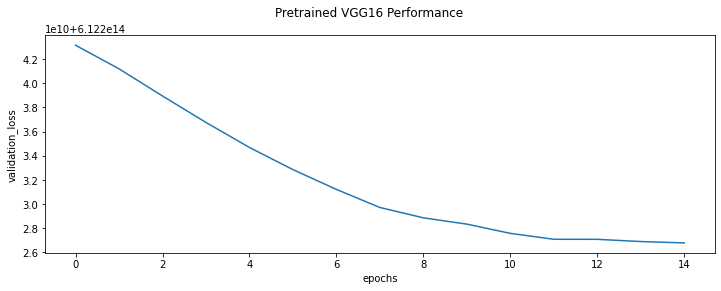

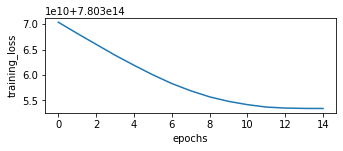

In [ ]:
plt.figure(1, figsize=(12, 4))
plt.suptitle('Pretrained VGG16 Performance', fontsize=12)
plt.subplot(111)
plt.ylabel('validation_loss')
plt.xlabel('epochs')
plt.plot(validation_loss)

plt.figure(2, figsize=(12, 4))
plt.subplot(222)
plt.ylabel('training_loss')
plt.xlabel('epochs')
plt.plot(training_loss)
plt.subplots_adjust(top=0.85, wspace=0.3)